Tommaso Peritore

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib.gridspec import GridSpec


import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
#from tensorflow.keras import backend as K
#from tensorflow.keras.utils import get_custom_objects

import itertools
import seaborn as sns


# Exercise 11

## Overview 


In this notebook our task will be to perform machine learning regression on noisy data with a Neural Network (NN).

We will explore how the ability to fit depends on the structure of the NN. The goal is also to build intuition about why prediction is difficult.

### The Prediction Problem


Consider a probabilistic process that gives rise to labeled data $(x,y)$. The data is generated by drawing samples from the equation

$$
    y_i= f(x_i) + \eta_i,
$$

where $f(x_i)$ is some fixed, but (possibly unknown) function, and $\eta_i$ is a Gaussian, uncorrelate noise variable such that

$$
\langle \eta_i \rangle=0 \\
\langle \eta_i \eta_j \rangle = \delta_{ij} \sigma
$$

We will refer to the $f(x_i)$ as the **true features** used to generate the data. 

To make predictions, we will consider a NN that depends on its parameters, weights and biases. The functions that the NN can model respresent the **model class** that we are using to try to model the data and make predictions.

To learn the parameters of the NN, we will train our models on a **training data set** and then test the effectiveness of the NN on a *different* dataset, the **validation data set**. The reason we must divide our data into a training and test dataset is that the point of machine learning is to make accurate predictions about new data we have not seen.

To measure our ability to predict, we will learn our parameters by fitting our training dataset and then making predictions on our test data set. One common measure of predictive  performance of our algorithm is to compare the predictions,$\{y_j^\mathrm{pred}\}$, to the true values $\{y_j\}$. A commonly employed measure for this is the sum of the mean square-error (MSE) on the test set:
$$
MSE= \frac{1}{N_\mathrm{test}}\sum_{j=1}^{N_\mathrm{test}} (y_j^\mathrm{pred}-y_j)^2
$$

We will try to get a qualitative picture by examining plots on validation and training data.

### Linear fit


We start by considering the very simple case:
$$
f(x)=2x+1
$$

Let's start defining the parameters of an ideal linear function which we are going to predict through a neural network regression

In [ ]:
# target parameters of f(x) = m*x + b
m = 2 # slope
b = 1 # intersect

Now let's generate a set of input data which will slightly deviate from our ideal behaviour using a random noise (that actually is set to zero):

In [ ]:
# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 500)
x_valid = np.random.uniform(-1, 1, 50)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function

sigma = 1 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)

In [ ]:
# plot validation and target dataset
plt.plot(x_valid, y_target, label='target')
plt.scatter(x_valid, y_valid, color='r', label='validation data')
plt.legend()
plt.grid(True)
plt.show()

### NN Model setup

If you remember how a single node of a neural network works, you can easily spot that **just a single neuron can make the job**. So let's start using a simple Sequential model with just one layer on one neuron only!

In [ ]:
# compose the NN model
model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,)))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

In [ ]:
# get a summary of our composed model
model.summary()

### Model training

We are now going to train our model, that is we feed the neuron with the set of training pair x, y_train from which the optimizer will find the best weights to minimize the Mean Square Error loss function (out linear regression function).

In [ ]:
# fit the model using training dataset
# over 10 epochs of 32 batch size each
# report training progress against validation data
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=30,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

By looking at weights and biases we can see if the linear fit was successfull: $w_1$ represents the angular coefficient, $b$ the intercept.

In [ ]:
# return weights and biases
model.get_weights()

### Model validation

In [ ]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# evaluate model with the exact curve
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [ ]:
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted, color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

## 11.1

In order to make practice with NN, explore how does the previous linear regression depend on the number of epochs, $N_{\mathrm{epochs}}$, the number of data points $N_{\mathrm{train}}$ and on the noise $\sigma$. Try to improve the previous result operating on these parameters.

## Solution

We want to explore how the linear regression depends on the number of epochs, the number of data points and the noise $\sigma$. We are interested in seeing how these parameters affect the ability of the NN to fit the data.

To explore the effect of all parameters we will define a set of values for each and then loop over all possible combinations of these values. 

In [15]:
# Parameters to vary
_sigma = [0.1, 0.2, 0.5, 1] # <<< noise
_n_epochs = [10, 15, 30, 50] # <<< epochs
_n_train = [500, 1000, 1500, 2000] # <<< train

N_valid = 50 # <<< test

# target parameters of f(x) = m*x + q
m = 2 # slope
q = 1 # intersect

print('Sigma = ', _sigma)
print('N_epochs = ', _n_epochs)
print('N_train = ', _n_train)

Sigma =  [0.1, 0.2, 0.5, 1]
N_epochs =  [10, 15, 30, 50]
N_train =  [500, 1000, 1500, 2000]


These parameters were chosen with these criteria in mind:
- The values of sigma were chosen to span from very low noise to very high noise so as to explore the ability of the NN model to fit the data in the presence of noise.
- The number of epochs was chosen to span from below to above the value given in the original code to a lot more epochs, to see if $30$ epochs was already enough to saturate the training or if more epochs would improve the fit, and if less epochs would be enough to fit the data.
- Finally, the number of training data was varied significantly to see if the model would perform better after having been trained on more data.

Below I am going to define a function to prepare the data, define the model, compile it and finally train it. This function will be used to fill a `loss` array with the values of the loss function for each combination of parameters.

In [16]:
# Define the function for the NN model
def run_model (sigma, n_epochs, train, valid):
	# generate training inputs
	np.random.seed(0)
	x_train = np.random.uniform(-1, 1, train)
	x_valid = np.random.uniform(-1, 1, valid)
	x_valid.sort()
	# y_target = m * x_valid + q # ideal (target) linear function

	# actual measures from which we want to guess regression parameters
	y_train = np.random.normal(m * x_train + q, sigma) 
	y_valid = np.random.normal(m * x_valid + q, sigma)

	# compose the NN model
	model = tf.keras.Sequential()
	model.add(Dense(1, input_shape = (1,)))

	# compile the model choosing optimizer, loss and metrics objects
	model.compile(optimizer = 'sgd', loss = 'mse', metrics = ['mse'])

	# train the model
	model.fit(x = x_train, y = y_train, batch_size = 32, epochs = n_epochs,
                    shuffle = True, validation_data = (x_valid, y_valid))
	score = model.evaluate(x_valid, y_valid, batch_size = 32, verbose = 0)
	
	return score[0]	

In [34]:
# Iterate model over all combinations of parameters
param_combinations = list(itertools.product(_sigma, _n_epochs, _n_train))

loss = []

for combination in param_combinations:
	loss.append(run_model (combination[0], combination[1], combination[2], N_valid))

Epoch 1/10
16/16 [==============================] - 0s 5ms/step - loss: 0.9663 - mse: 0.9663 - val_loss: 0.7162 - val_mse: 0.7162
Epoch 2/10
16/16 [==============================] - 0s 1ms/step - loss: 0.5750 - mse: 0.5750 - val_loss: 0.4390 - val_mse: 0.4390
Epoch 3/10
16/16 [==============================] - 0s 1ms/step - loss: 0.3578 - mse: 0.3578 - val_loss: 0.2823 - val_mse: 0.2823
Epoch 4/10
16/16 [==============================] - 0s 1ms/step - loss: 0.2339 - mse: 0.2339 - val_loss: 0.1895 - val_mse: 0.1895
Epoch 5/10
16/16 [==============================] - 0s 1ms/step - loss: 0.1599 - mse: 0.1599 - val_loss: 0.1335 - val_mse: 0.1335
Epoch 6/10
16/16 [==============================] - 0s 1ms/step - loss: 0.1149 - mse: 0.1149 - val_loss: 0.0985 - val_mse: 0.0985
Epoch 7/10
16/16 [==============================] - 0s 1ms/step - loss: 0.0863 - mse: 0.0863 - val_loss: 0.0755 - val_mse: 0.0755
Epoch 8/10
16/16 [==============================] - 0s 1ms/step - loss: 0.0672 - mse: 0.06

Finally now that we have the loss array, we are going to visualize the data obtained. I am using heatmaps to visualize the loss obtained from the model as a function of the number of epochs, the number of training data and the noise $\sigma$. With fixed number of `N_train`, each heatmap gives the values of the loss with respect to the number of epochs (on the x-axis) and the noise $\sigma$ (on the y-axis). 

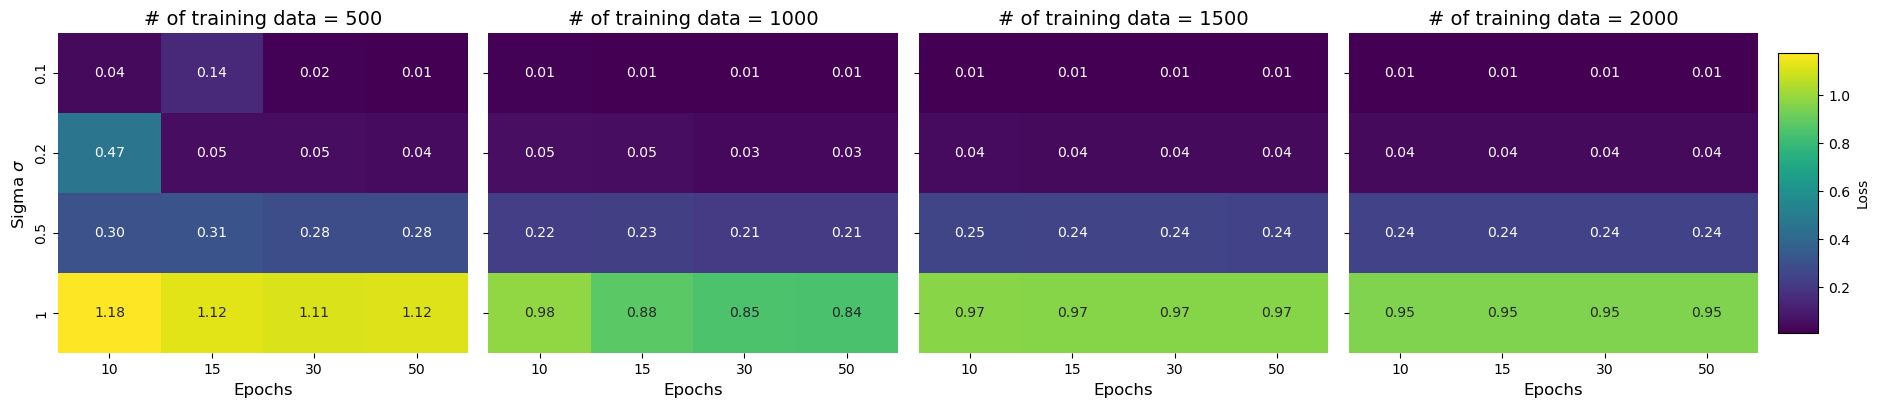

In [41]:
# Function to plot heatmaps
def plot_heatmaps(loss, param_combinations, sigma_values, n_epochs_values, n_train_values):
    fig = plt.figure(figsize=(20, 4))
    gs = GridSpec(1, len(n_train_values), width_ratios=[1]*len(n_train_values), wspace=0.05)
    
    # Calculate the min and max of the loss values
    vmin = min(loss)
    vmax = max(loss)
    
    axes = []
    for i, n_train in enumerate(n_train_values):
        ax = fig.add_subplot(gs[i])
        axes.append(ax)
        
        # Filter the loss values for the current n_train
        filtered_loss = [loss[j] for j in range(len(loss)) if param_combinations[j][2] == n_train]
        
        # Reshape the filtered loss into a matrix
        loss_matrix = np.array(filtered_loss).reshape(len(sigma_values), len(n_epochs_values))
        
        # Plot heatmap
        sns.heatmap(
            loss_matrix, annot=True, fmt='.2f', ax=ax, cmap='viridis', vmin=vmin, vmax=vmax,
            cbar=False,  # Disable individual colorbars
            xticklabels=n_epochs_values, yticklabels=sigma_values
        )
        
        ax.set_title(f'# of training data = {n_train}', fontsize=14)
        ax.set_xlabel('Epochs', fontsize=12)
        
        if i == 0:
            ax.set_ylabel('Sigma $\sigma$', fontsize=12)
        else:
            ax.set_ylabel('')
            ax.tick_params(labelleft=False)
    
    plt.subplots_adjust(left=0.05, right=0.9, top=0.9, bottom=0.1, wspace=0.2)
    cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])
    plt.colorbar(axes[0].collections[0], cax=cbar_ax).set_label('Loss')
    
    plt.show()

# Plot the heatmaps
plot_heatmaps(loss, param_combinations, _sigma, _n_epochs, _n_train)

Despite being not too easy to read as a data visualization method, these heatmaps actually contain a lot of information about the performance of the model.

First off, looking at the difference of the same point in the heatmaps (fixed sigma and epochs) throughout the difference plots, i.e. different number of traning data, we can see how the loss function did not decrease directly with the increase of training data: it saw an improvement when going from $500$ to $1000$, but after that the loss got worse. We can interpret this as an overfitting of the model which with more training data got worse in predicting the test data.

The second observation is that with fixed sigma and number of training data, the loss did not vary significantly with the number of epochs (horizontally within a heatmap). This shows how number of epochs does not affect the loss function significantly, and that the model saturates after a certain number of epochs. This number can be seen varying with training data, but we can affirm that after $15$ epochs, the loss does not get much better.

Finally, we can see that the loss function increases with the noise $\sigma$, as expected.

### Backend - original code

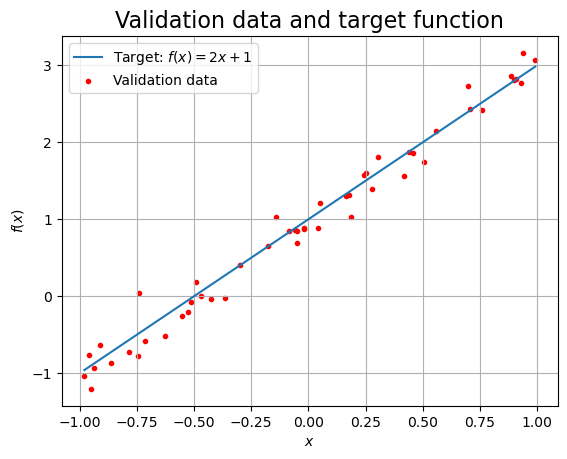

In [36]:
# generate training parameters
N_epochs = 30
N_train = 1000 # <<< train
N_valid = 50 # <<< test
sigma = 0.2
bach_size = 32

# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, N_train)
x_valid = np.random.uniform(-1, 1, N_valid)
x_valid.sort()
y_target = m * x_valid + q # ideal (target) linear function

# actual measures from which we want to guess regression parameters
y_train = np.random.normal(m * x_train + q, sigma) 
y_valid = np.random.normal(m * x_valid + q, sigma)

# plot validation and target dataset
plt.plot(x_valid, y_target, label = 'Target: $f(x)= 2x +1$')
plt.scatter(x_valid, y_valid, color = 'r', marker = '.', label = 'Validation data')
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title("Validation data and target function", fontsize = 16)
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# ==============================================
# INITIALIZE Neural Network (Sequential) model:
# a single neuron can make the fitting job, so
# i use only one layer on one neuron.
# ==============================================
model = tf.keras.Sequential()
model.add(Dense(1, input_shape = (1,)))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer = 'sgd', loss = 'mse', metrics = ['mse'])

# ==============================================
# TRAIN THE MODEL 
# I feed the neuron with the set of (x,y) training 
# pairs. The optimizer finds the best weights 
# minimizing the Mean Square Error loss function 
# ==============================================

history = model.fit(x = x_train, y = y_train, batch_size = 32, epochs = N_epochs,
                    shuffle = True, validation_data = (x_valid, y_valid))

Epoch 1/30
32/32 [==============================] - 0s 2ms/step - loss: 3.9973 - mse: 3.9973 - val_loss: 3.1475 - val_mse: 3.1475
Epoch 2/30
32/32 [==============================] - 0s 783us/step - loss: 2.3927 - mse: 2.3927 - val_loss: 2.0029 - val_mse: 2.0029
Epoch 3/30
32/32 [==============================] - 0s 744us/step - loss: 1.5125 - mse: 1.5125 - val_loss: 1.3213 - val_mse: 1.3213
Epoch 4/30
32/32 [==============================] - 0s 724us/step - loss: 0.9876 - mse: 0.9876 - val_loss: 0.8745 - val_mse: 0.8745
Epoch 5/30
32/32 [==============================] - 0s 736us/step - loss: 0.6460 - mse: 0.6460 - val_loss: 0.5932 - val_mse: 0.5932
Epoch 6/30
32/32 [==============================] - 0s 699us/step - loss: 0.4337 - mse: 0.4337 - val_loss: 0.4062 - val_mse: 0.4062
Epoch 7/30
32/32 [==============================] - 0s 831us/step - loss: 0.2951 - mse: 0.2951 - val_loss: 0.2832 - val_mse: 0.2832
Epoch 8/30
32/32 [==============================] - 0s 737us/step - loss: 0.20

In [38]:
print("Results")
w,b = model.get_weights()
print("Slope   m = " + str(w[0][0]))
print("Interc. q = " + str(b[0]))
print()
print()

# evaluate with TEST data
print("TEST DATA evaluation")
score = model.evaluate(x_valid, y_valid, batch_size = 32, verbose = 0)
print('Test loss: ', score[0])
print()

#evaluate with the EXACT CURVE with m = 2 and q = 1
print("EXACT CURVE evaluation")
score = model.evaluate(x_valid, y_target, batch_size = 32, verbose = 0)
print('Test loss: ', score[0])

Results
Slope   m = 1.9882325
Interc. q = 1.0062877


TEST DATA evaluation
Test loss:  0.03386206179857254

EXACT CURVE evaluation
Test loss:  9.404189768247306e-05


4/4 [==============================] - 0s 577us/step


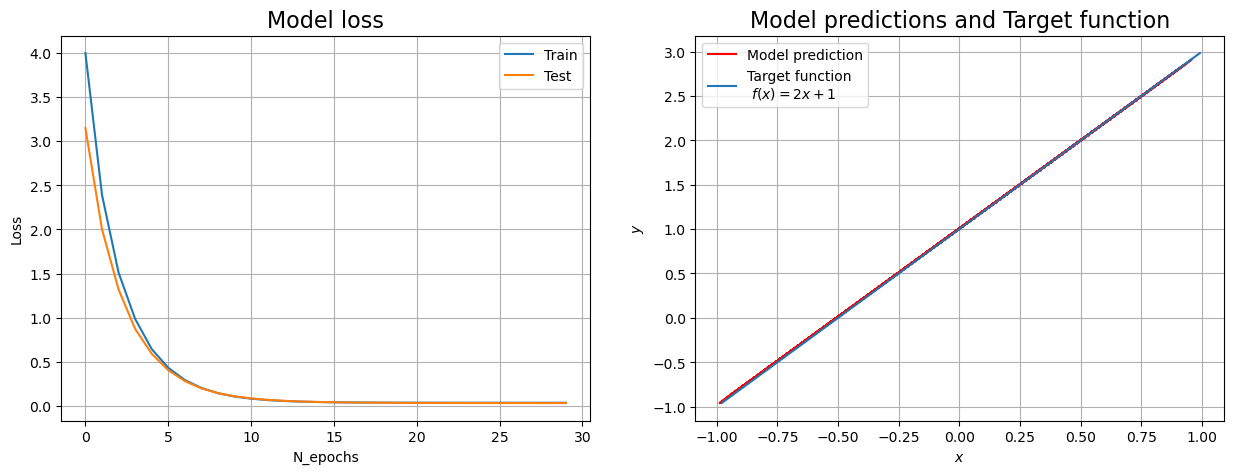

In [39]:
plt.figure(figsize = (15, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss', fontsize = '16')
plt.ylabel('Loss')
plt.xlabel('N_epochs')
plt.legend(['Train', 'Test'])
plt.grid()

# ==============================================
# COMPARE MODEL predictions with TARGET FUNCTION
# ==============================================

# generate predictions
x_predicted = np.random.uniform(-1, 1, 100) 
y_predicted = model.predict(x_predicted)

# plot
plt.subplot(1, 2, 2)
plt.plot(x_predicted, y_predicted, color='r', label = "Model prediction")
plt.plot(x_valid, y_target, label = "Target function\n $f(x) = 2x+1$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Model predictions and Target function", fontsize = 16)
plt.grid()
plt.legend()
plt.show()

In [40]:
# Separate the parameters and losses into individual arrays
sigma, n_train, n_epochs = zip(*param_combinations)
loss = np.array(loss)

# Create a trace for the 3D plot
trace = go.Scatter3d(
    x=sigma,
    y=n_train,
    z=n_epochs,
    mode='markers',
    marker=dict(
        size=4,
        color=loss,  # Use the log-transformed loss for coloring
        colorscale='Viridis',
        colorbar=dict(title='Log(Loss)'),
        opacity=0.9
    ),
    text=[f'Sigma: {s}<br>Train data: {t}<br>Epochs: {e}<br>Loss: {l:.4f}'
          for s, t, e, l in zip(sigma, n_train, n_epochs, loss)],
    hoverinfo='text'
)

# Create the layout
layout = go.Layout(
    title='3D Scatter Plot of Loss with Different Parameters',
    scene=dict(
        xaxis=dict(title=f'sigma', titlefont=dict(size=12)),
        yaxis=dict(title='train data', titlefont=dict(size=12)),
        zaxis=dict(title='epochs', titlefont=dict(size=12))
    ),
    width=900,  # Increase the width of the plot
    height=700,  # Increase the height of the plot
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()